# Diffusion Equation in 1D

In this notebook, we compare the solution found with our time-stepping PDE solver against the known analytical solution to the diffusion equation. 

The diffusion equation in 1D is
$$
\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2},
$$
where $u(x,t)$ is the density of some material and $D$ is the diffusivity of the material.

Starting from an initial condition
$$
u(x, t_0) = \frac{1}{\sqrt{4 \pi D t_0}} \exp^{-x^2 / 4 D t_0},
$$
at time $t_0$, the diffusion equation has an analytical solution
$$
u(x, t) = \frac{1}{\sqrt{4 \pi D t}} \exp^{-x^2 / 4 D t}
$$
at a later time $t$.

In [2]:
import jax.numpy as jnp
from matplotlib import pyplot as plt

from jax_fno import solver

In [ ]:
###################################
# Parameterised governing equations
###################################


def laplacian_dirichlet_1d(
    u: jnp.ndarray, 
    bc_left: float, 
    bc_right: float, 
    dx: float
) -> jnp.ndarray:
    """
    Take the Laplacian in a finite difference approach.

    Assumes the boundary points are ghost points with Dirichlet conditions.

    The derivative

    Args:
        u: The array to be differenced
        bc_left: The value at the left boundary (i.e. first ghost point)
        bc_right: The value at the right boundary (i.e. last ghost point)
        dx: The grid spacing
    """
    return jnp.diff(jnp.diff(u, prepend=bc_left, append=bc_right)) / dx**2


def heat_rhs_dirichlet(
    u: jnp.ndarray,
    t: float,
    diffusivity: float,
    bc_left: float,
    bc_right: float,
    dx: float,
) -> jnp.ndarray:
    """
    Return right-hand-side of heat equation du/dt = D d2u/dx2.

    Args:
        u: jnp.ndarray,
        t: float,
        diffusivity: float,
        bc_left: float,
        bc_right: float,
        dx: float
    """
    return diffusivity * laplacian_dirichlet_1d(u, bc_left, bc_right, dx)


def jvp_heat_rhs_dirichlet(
    u: jnp.ndarray,
    t: float,
    v: jnp.ndarray,
    diffusivity: float,
    bc_left: float,
    bc_right: float,
    dx: float,
) -> jnp.ndarray:
    """
    Return the matrix-free Jacobian df/du * v where f(u) = D d2u/dx2.
    """
    return diffusivity * laplacian_dirichlet_1d(v, bc_left, bc_right, dx)


def heat_soln_dirichlet(
    x: jnp.ndarray, 
    t: float, 
    diffusivity: float,
    length: float
) -> jnp.ndarray:
    """
    Return the solution to a 1D heat equation with
        a Gaussian initial condition and Dirichlet boundary conditions.

    Initial condition at time t=1:
    u(x, 0) = exp(-(x-L/2)**2 / (4 * D * t0)) / j(4 * pi * D * t0)

    Boundary conditions:
    u(0, t) = u(L, t) = 0

    Solution at a later time t:
    u(x, t) = exp(-(x-L/2)**2 / (4 * D * t)) / (4 * pi * D * t)

    Args:
        x: Grid points
        t: Time
        D: Diffusivity
        L: Grid size
    """
    k = 1 / jnp.sqrt(4 * jnp.pi * diffusivity * t)
    return k * jnp.exp(-((x - length / 2) ** 2) / (4 * diffusivity * t))

In [ ]:
# Set parameters
length = 100.0  # domain length
nx = 128  # number of grid points
dx = length / (nx + 1)  # grid spacing if grid points are in the interior
diffusivity = 2.0  # diffusivity
bc_values = (0.0, 0.0)  # boundary condition values
t_span = (1.0, 10.0)  # (start_time, end_time)
x = jnp.linspace(dx, length - dx, nx, endpoint=True)  # grid

# Define equations
f = lambda u, t: heat_rhs_dirichlet(
    u, t, 
    diffusivity, bc_values[0], bc_values[1], dx
)

jvp = lambda u, t, v: jvp_heat_rhs_dirichlet(
    u, t, v, 
    diffusivity, bc_values[0], bc_values[1], dx
)

# Initial condition
u0 = heat_soln_dirichlet(x, t_span[0], diffusivity, length)

# Solve the equation
u, t = solver.solve_ivp(
    f,
    u0,
    t_span,
    dt=1e-1,
    stepper=solver.BackwardEuler(),
    jvp=jvp,
    save_every=20  # save every 20 steps (each save triggers recompilation)
)

# Compute the analytical solution
u_analytical = [
    heat_soln_dirichlet(x, t[i], diffusivity, length) for i in range(len(t))
]

# Compare at several time points
for i in range(len(t)):
    time = t[i]
    error = jnp.linalg.norm(u[i, :] - u_analytical[i]) / jnp.linalg.norm(
        u_analytical[i]
    )
    print(f"t={time:.3f}: relative error = {error:.3e}")


IndexError: Too many indices: 1-dimensional array indexed with 2 regular indices.

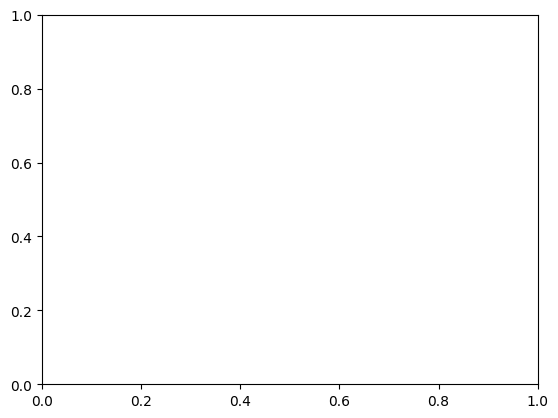

In [7]:
# Plot results
fig, ax = plt.subplots()
ax.plot(x, u[0, :], "-", marker=".", label=f"Numerical, $t={t[0]:.2f}$")
ax.plot(x, u_analytical[0], "--", label=f"Analytical, $t={t[0]:.2f}$")
ax.plot(x, u[-1, :], "-", marker=".", label=f"Numerical, $t={t[-1]:.2f}$")
ax.plot(x, u_analytical[-1], "--", label=f"Analytical, $t={t[-1]:.2f}$")
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("u")
plt.show()